## Introdução

Neste projeto, utilizaremos um [data set](https://www.kaggle.com/austinreese/craigslist-carstrucks-data/notebooks) de carros usados.  Iremos realizar uma análise dos dados, buscando compreender o comportamento estatístico de cada variável de forma individual, e possíveis dependências entre elas. Partindo da análise, criaremos um modelo que prevê o preço de um carro usado.

In [1]:
!git clone https://github.com/luan521/Teste_icarros.git

In [2]:
# Importando bibliotecas, que serão utilizadas no projeto:

import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [3]:
from Teste_icarros.Scaler import ReplaceOutliers
from Teste_icarros.Scaler import CustomScaler
from Teste_icarros.Funções_icarros import entropia
from Teste_icarros.Funções_icarros import inf_mutua

In [4]:
# Carregando os dados

df = pd.read_csv('vehicles.csv')
df.head()

,Unnamed: 0,id,url,region,region_url,price,year,manufacturer,model,condition,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.861600,-85.216100,2020-12-01T15:54:45-0600
4,4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.547500,-85.468200,2020-12-01T12:53:56-0600


Temos 26 colunas presentes no dataset fornecido, sendo vinte e cinco delas variáveis características (dados de entrada) e um delas (price) uma variável-alvo (que queremos que o nosso modelo seja capaz de prever).

Algumas variáveis caracteristicas, são claramente irrelevantes para o processo de análise e criação do modelo:
- Unnamed: 0
- id
- url
- region_url
- VIN
- image_url
- description

Percebe-se também a presença de valores ausentes no data set. Portanto, antes de começar o processo de análise, excluiremos as colunas acima, e faremos um processo de limpeza dos dados.

## Cleaning data

In [5]:
# Excluindo as colunas irrelevantes.

cols_drop = ['Unnamed: 0','id','url','region_url','VIN','image_url','description']
df1 = df.drop(cols_drop, axis = 1)

In [6]:
# Identificando a proporção de dados faltantes (em relação ao tamanho do data set), para cada coluna.

var_num = ['odometer','lat','long','year','posting_date']
var_cat = [c for c in df1.columns if c not in var_num+['price']]

print('Variáveis numéricas:\n',(df1[var_num].isnull().sum()/df1.shape[0]).sort_values(ascending=False), sep = '')
print('\nVariáveis categóricas:\n',(df1[var_cat].isnull().sum()/df1.shape[0]).sort_values(ascending=False), sep = '')

Variáveis numéricas:
odometer        0.120693
long            0.016254
lat             0.016254
year            0.002292
posting_date    0.000061
dtype: float64

Variáveis categóricas:
size            0.701307
condition       0.421071
cylinders       0.373494
paint_color     0.307375
drive           0.292851
type            0.246038
manufacturer    0.039763
model           0.010576
fuel            0.007064
title_status    0.005624
transmission    0.005329
state           0.000000
region          0.000000
dtype: float64


Tomaremos aqui a seguinte estratégia, para tratar os dados faltantes: 
- Se a quantidade de dados faltantes para uma dada coluna, representar menos que 1% do data set, então resolveremos o problema excluindo as observações com dados faltantes.
- Quando a hipótese acima não for satisfeita, e a coluna tratada for uma variável numérica, então substituimos o valor nulo pela média dos valores não nulos da coluna.
- Por último, quando a variável for categórica, substituimos os valores nulos pelo valor "missing".

In [7]:
mean_odometer = df1['odometer'].mean() # Média da coluna "odometer"
mean_long = df1['long'].mean() # Média da coluna "long"
mean_lat = df1['lat'].mean() # # Média da coluna "lat"

preenchimento = {c:'missing' for c in var_cat if df1[c].isnull().sum()/df1.shape[0] >= 0.01}
preenchimento['odometer'] = mean_odometer
preenchimento['long'] = mean_long
preenchimento['lat'] = mean_lat

df2 = df1.fillna(preenchimento)
df2 = df2.dropna() 

In [8]:
print('Dados excluidos: ',round(100*(1-df2.shape[0]/df.shape[0]),3),'%', sep = '')

Dados excluidos: 1.51%


In [9]:
print('Variáveis numéricas:\n',(df2[var_num].isnull().sum()/df2.shape[0]).sort_values(ascending=False), sep = '')
print('\nVariáveis categóricas:\n',(df2[var_cat].isnull().sum()/df2.shape[0]).sort_values(ascending=False), sep = '')

Variáveis numéricas:
posting_date    0.0
year            0.0
long            0.0
lat             0.0
odometer        0.0
dtype: float64

Variáveis categóricas:
state           0.0
paint_color     0.0
type            0.0
size            0.0
drive           0.0
transmission    0.0
title_status    0.0
fuel            0.0
cylinders       0.0
condition       0.0
model           0.0
manufacturer    0.0
region          0.0
dtype: float64



Neste momento, nosso data set não possui valores nulos. Resta agora um problema na coluna preço, como pode-se observar no gráfico abaixo, existem preços com valor 0, o que não condiz com o preço de um carro. Como não podemos manipular a variável alvo, pois é esta que buscaremos prever, devemos excluir estes dados.


C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

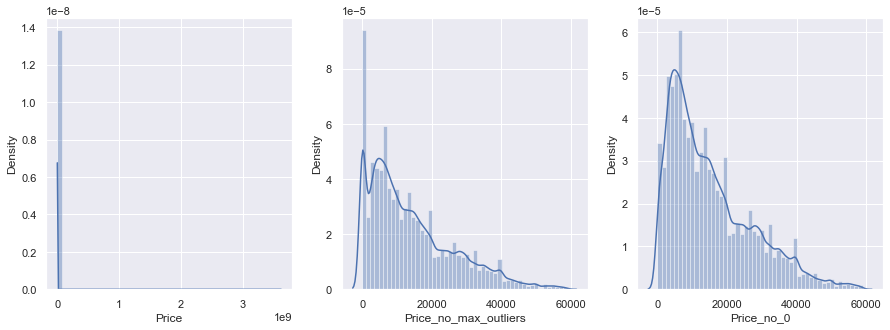

In [10]:
q = df2['price'].quantile(0.99)
price = df2['price'][df2['price'] < q]
price_no_0 = price[price > 0]

price_df = pd.DataFrame({'Price': df2['price'],'Price_no_max_outliers': price, 'Price_no_0': price_no_0})

sns.set(rc={"figure.figsize": (15, 5)})

plt.subplot(1,3,1)
sns.distplot(price_df['Price'])

plt.subplot(1,3,2)
sns.distplot(price_df['Price_no_max_outliers'])

plt.subplot(1,3,3)
sns.distplot(price_df['Price_no_0'])

plt.show()

In [11]:
# Excluindo os dados, tais que preço < 10.

df3 = df2[df2['price'] > 10]
df3.index = range(df3.shape[0])

In [12]:
print('Dados excluidos: ',round(100*(1-df3.shape[0]/df.shape[0]),2),'%', sep = '')

Dados excluidos: 9.03%


Ao final do nosso processo de limpeza dos dados, 9.03% dos dados iniciais foram perdidos. 

Antes de entrar no processo de análise, vamos ordenar as colunas do data set, deixando por último a variável alvo (price). Vamos também dividir os dados em train, validation e test. Toda a análise será realizada nos dados train, em seguida o modelo será criado e treinado em cima desses dados, os dados validation serão utilizados para validar o modelo, neste estágio teremos liberdade para modificar alguns parâmetros e treinar o modelo novamente em cima dos dados train, buscando atingir a melhor precisão em cima dos dados validation. Por último, os dados test serão utilizados para calcular a precisão final do modelo.

In [13]:
df3.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [14]:
# Ordenando as colunas do data set, colocando a variável alvo (price) por último.

df3 = df3[['region', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long','price']]

In [15]:
# Randomizando os índices do data set, e dividindo em train, validation e test.

qt_train_data = int(0.7*df3.shape[0]) 
qt_validation_data = int(0.15*df3.shape[0])

ind = np.arange(df3.shape[0])
np.random.shuffle(ind)
ind_train_data = ind[:qt_train_data]
ind_validation_data = ind[qt_train_data:qt_train_data + qt_validation_data]
ind_test_data = ind[qt_train_data + qt_validation_data:]

df_train0 = df3.loc[ind_train_data,:]
df_train0.index = range(df_train0.shape[0])
df_validation0 = df3.loc[ind_validation_data,:]
df_validation0.index = range(df_validation0.shape[0])
df_test0 = df3.loc[ind_test_data,:]
df_test0.index = range(df_test0.shape[0])

## Analysis

Começaremos analisando a coluna alvo (price), ja visializamos a distribuição dessa variável anteriormente, e é possível perceber uma assimetria positiva nessa distribuição, isto é, existem carros com preços muito elevados em relação a maioria. Estes outliers podem levar o modelo a se desviar do comportamento médio seguido pelos dados. 

C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


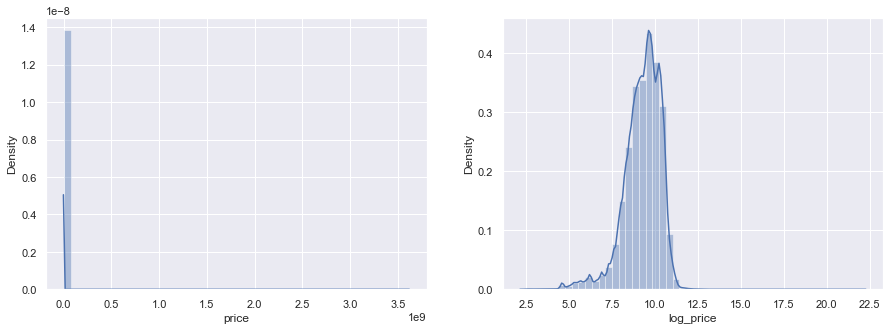

In [16]:
sns.set(rc={"figure.figsize": (15, 5)})

plt.subplot(1,2,1)
sns.distplot(df_train0['price'])

plt.subplot(1,2,2)
log_price = pd.Series(df_train0['price'].apply(m.log), name = 'log_price')
sns.distplot(log_price)

plt.show()

In [17]:

measure = ['Mean', 'Median', 'Mode']
measure_price = [round(df_train0['price'].mean(),2), round(df_train0['price'].median(),2), round(df_train0['price'].mode()[0],2)]
measure_log_price = [round(log_price.mean(),2), round(log_price.median(),2), round(log_price.mode()[0],2)]

measure_df = pd.DataFrame({'Measure':measure,'Price': measure_price, 'Log_Price': measure_log_price})
measure_df

,Measure,Price,Log_Price
0,Mean,55127.26,9.26
1,Median,12172.00,9.41
2,Mode,6995.00,8.85


Os gráficos exibidos, assim como a tabela acima, mostram que aplicando a transformação logarítmica na variável price, os dados passam a seguir uma distribuição mais próxima de uma Gaussiana. A média, mediana e moda da coluna Log_Price são valores próximos, enquanto que para a coluna Price, estes valores encontram-se distantes uns dos outros, evidenciando a simetria na distribuição de Log_price e assimetria na distribuição da coluna Price.

Contudo, criaremos uma nova coluna, que é a transformação logarítmica da variável price.

In [18]:
# Criando uma nova coluna, que é o log da coluna álvo (price).

df_train0['log_price'] = df_train0['price'].apply(m.log)


Vamos analisar agora as variáveis odometer, que nos diz a kilometragem percorrida pelo carro, e year, que nos diz o ano em que o carro foi produzido. Pelo gráfico gerado abaixo, vemos que existem carros antigos fugindo do comportamento médio dos dados, e carros que percorreram uma quilometragem muito maior do que a média dos dados. Trataremos este problema eliminando uma parte dos dados que contêm estes outliers 

Estas variáveis estão intrisicamente relacionadas, quanto mais velho o carro maior deve ser a quilometragem percorrida. Voltaremos a este assunto mais a frente, quando estivermos analisando relações de dependência entre as variáveis.


C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


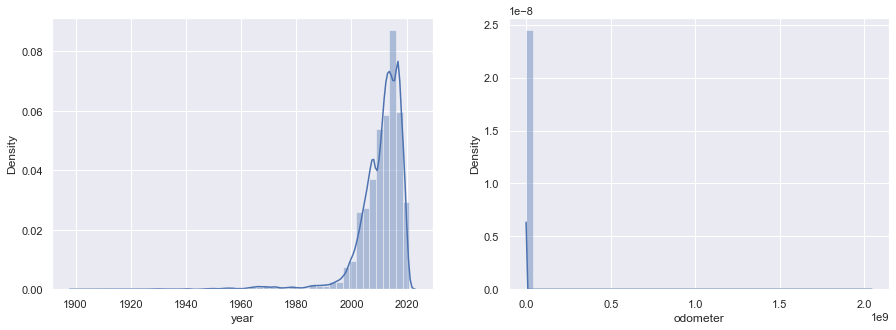

In [19]:
sns.set(rc={"figure.figsize": (15, 5)})

plt.subplot(1,2,1)
sns.distplot(df_train0['year'])

plt.subplot(1,2,2)
sns.distplot(df_train0['odometer'])

plt.show()

In [20]:
q_odometer = df_train0['odometer'].quantile(0.99)
q_year = df_train0['year'].quantile(0.01)

df_train1 = df_train0[df_train0['odometer'] < q_odometer]
df_train1 = df_train1[df_train1['year'] > q_year]

df_train1.index = range(df_train1.shape[0])

In [21]:
cols_scaler = ['year','odometer']
scaler = CustomScaler(cols_scaler)

In [22]:
scaler.fit(df_train1)
df_train1 = scaler.transform(df_train1)

C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


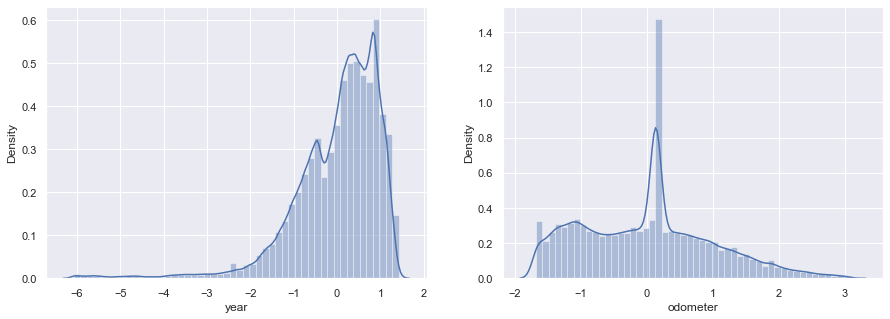

In [23]:
sns.set(rc={"figure.figsize": (15, 5)})

plt.subplot(1,2,1)
sns.distplot(df_train1['year'])

plt.subplot(1,2,2)
sns.distplot(df_train1['odometer'])

plt.show()


As variáveis long e lat devem ser exibidas juntas, pois representam as coordenadas do local em que ocorreu a venda do carro. Abaixo, segue a plotagem desses dados, onde podemos perceber uma concentração de pontos na América do Norte.


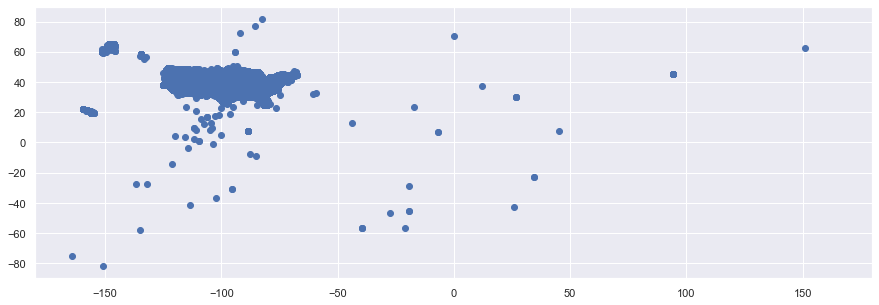

In [24]:
plt.scatter(df_train1['long'],df_train1['lat'])

plt.xlim(-180,180)
plt.ylim(-90,90)
plt.show()

Vamos agora passar para as variáveis categóricas, abaixo seguem algumas informações gerais. Se analisarmos as variáveis region e state, elas possuem respectivamente 405 e 51 valores. A variável state funciona como um clustering da variável region, que por sua vez funciona como um clustering para as variáveis lat e long. Contudo, é mais eficiente continuarmos trabalhando apenas com a variável state.

Uma outra tabela foi feita em seguida, para mostrar quais variáveis possuem, ou muitos valores únicos, ou um único valor que ocorre com frequência muito elevada, ambos os casos são problemáticos e devem ser evitados.


In [25]:
df_train1[var_cat].describe()

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
count,285828,285828,285828,285828,285828,285828,285828,285828,285828,285828,285828,285828,285828
unique,405,44,22844,7,9,5,6,3,4,5,14,13,51
top,rochester,ford,f-150,missing,missing,gas,clean,automatic,4wd,missing,missing,missing,ca
freq,2356,48676,4938,112932,103279,253451,275235,248697,87846,200676,70557,86072,32118


In [26]:
top = df_train1[var_cat].describe().loc['top',:]
freq = df_train1[var_cat].describe().loc['freq',:]/df_train1.shape[0]
unique = df_train1[var_cat].describe().loc['unique',:]

pd.DataFrame({'top': top, 'freq': freq, 'unique': unique}).sort_values('freq', ascending=False)

,top,freq,unique
title_status,clean,0.962939,6
fuel,gas,0.886726,5
transmission,automatic,0.870093,3
size,missing,0.702087,5
condition,missing,0.395105,7
cylinders,missing,0.361333,9
drive,4wd,0.307339,4
paint_color,missing,0.301132,13
type,missing,0.246851,14
manufacturer,ford,0.170298,44


In [27]:
cols_drop = ['title_status','fuel','transmission','size','model','region']
df_train2 = df_train1.drop(cols_drop,axis = 1)

In [28]:
var_cat = ['manufacturer','condition','cylinders', 'drive','type','paint_color','state']
replace = ReplaceOutliers(var_cat,0.99)
replace.fit(df_train2)

In [29]:
df_train2 = replace.transform(df_train2)

Para analisar como as variáveis características categóricas estão relacionadas entre si, utilizaremos conceitos de Teoria da informação. Esta teoria fornece uma medida do quanto de informação existe em uma variável aleatória (entropia), e ao tomar duas variáveis, ela fornece uma maneira de quantificar o quanto que uma variável possui de informação em relação a outra(informação mutua). 

A informação mutua I(X,Y) é simétrica em relação as variáveis, ou seja: I(X,Y) = I(Y,X). Mas como dito anteriormente, também conseguimos quantificar a informação individual de cada variável, H(X) e H(y), esta função é chamada entropia. Se tomarmos então a medida I(X,Y)/H(X), estaremos medindo o quanto da informção de X, que esta contido na variável , sendo 0 <= I(X,Y)/H(X)<= 1.

Utilizaremos então a medida I(X,Y)/H(X) para saber o quanto da informação de cada variável característica, está contida nas demais. Uma biblioteca foi criada, com duas funções, uma que calcula a entropia de uma coluna e outra que calcula a informação mutua de duas colunas.

Vamos aproveitar, e incluir a variável alvo (price) nesta análise, para isso precisamos discretizar esta variável.


![alt text](https://i.imgur.com/dowaInY.jpg)
![alt text](https://i.imgur.com/zARCk72.png)

In [30]:
# Discretizando a variável alvo

qt_intervalos = 5

kmeans = KMeans(qt_intervalos)

kmeans.fit(df_train2[['price']])
price_cat = kmeans.fit_predict(df_train2[['price']])

In [31]:
var_cat_inf = ['condition', 'cylinders', 'drive', 'paint_color', 'type', 'manufacturer', 'state']
dados = df_train2[var_cat_inf]
dados['price'] = price_cat

C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
comb_var = [(v1,v2) for v1 in dados.columns for v2 in dados.columns]
matriz_inf = pd.DataFrame(data = comb_var, columns = ['Variável_1', 'Variável_2'])

col_inf = []
for i in range(matriz_inf.shape[0]):
    
    col_1 = matriz_inf['Variável_1'][i]
    col_2 = matriz_inf['Variável_2'][i]
    
    if col_1 == col_2:
        col_inf.append(1.0)
    else:
        col_inf.append(inf_mutua(dados[[col_1,col_2]])/entropia(dados[col_1]))

matriz_inf['Informação'] = col_inf

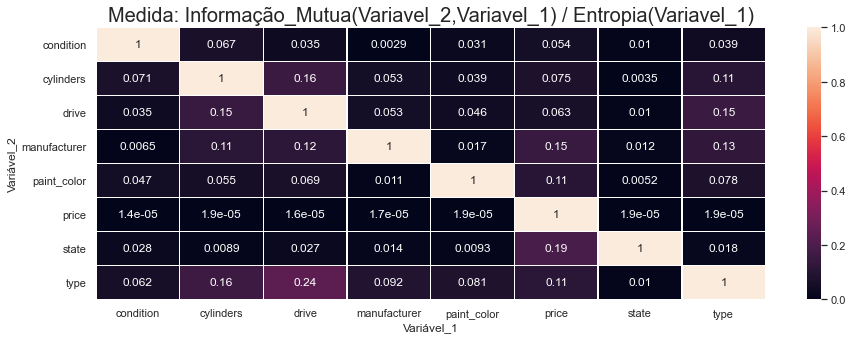

In [33]:
heat_inf = matriz_inf.pivot("Variável_2", "Variável_1", "Informação") 

plt.title('Medida: Informação_Mutua(Variavel_2,Variavel_1) / Entropia(Variavel_1)', fontsize=20)
sns.set(rc={"figure.figsize": (15, 10)})
sns.heatmap(heat_inf, linewidths=.5,annot=True,vmin=0, vmax=1)

plt.show()


Acima, temos uma representação do quanto que cada variável de uma dada linha, possui da informação de uma variável em uma certa coluna. Os elementos na diagonal são todos iguais a 1, isso apenas indica que cada variável possui informação completa sobre si mesma. Podemos ver por exemplo, que 24% da informação da variável drive esta contida na variável type. 

Em um cenário ideal, a coluna da variável price estaria o mais clareada possível, indicando que todas as variáveis característica consideradas, possuem informação relevante da variável alvo. E todas as outras células (com exceção da diagonal), estariam escuras, indicando que as variáveis característica são independentes.

A variável característica que mais se aproxima do padrão ideal é a variável state, possuindo 19% de toda informação contida na variável price, e pouca informação em relação as outras variáveis.


In [34]:
var_cat = ['condition', 'cylinders', 'drive', 'paint_color', 'type', 'manufacturer', 'state']
dados = df_train2[var_cat_inf + ['log_price']]

In [35]:
measure = ['Mean','Std','Median','Mode']
measure_vars = {}
for var in var_cat:    
    measure_referencia = [round(dados['log_price'].mean(),2), round(dados['log_price'].std(),2), round(dados['log_price'].median(),2), round(dados['log_price'].mode()[0],2)]
    measure_df = pd.DataFrame({'Measure': measure, 'Referência': measure_referencia})
    for pos in dados[var].unique():
        log_price_pos = dados['log_price'][dados[var] == pos]
        measure_pos = [round(log_price_pos.mean(),2), round(log_price_pos.std(),2), round(log_price_pos.median(),2), round(log_price_pos.mode()[0],2)]
        measure_df[pos] = measure_pos
    measure_vars[var] = measure_df

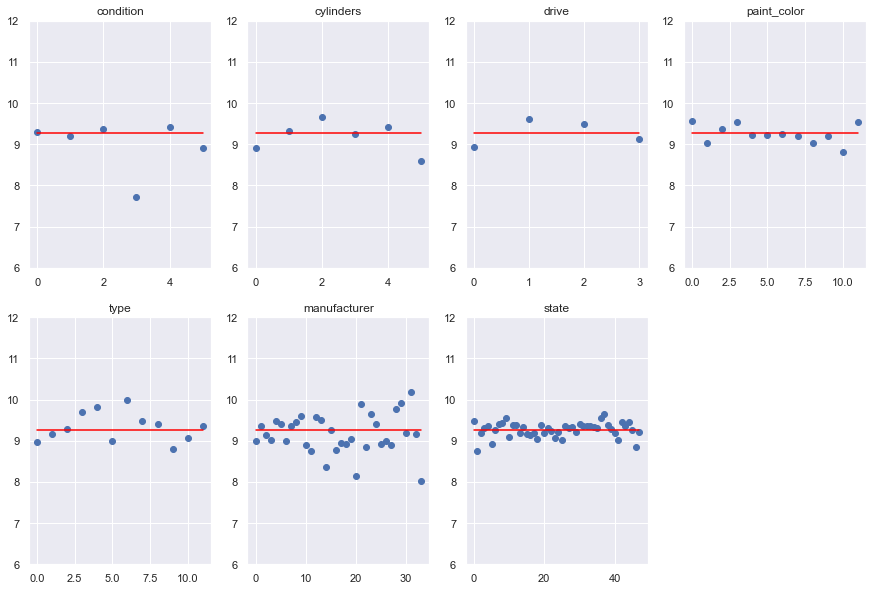

In [36]:
sns.set(rc={"figure.figsize": (15, 10)})
for i in range(len(var_cat)):
    var = var_cat[i]
    plt.subplot(2,4,i+1)

    plt.title(var)
    mean_referencia = measure_vars[var]['Referência'][0]
    referencia = [mean_referencia for i in range(measure_vars[var].shape[1]-2)]
    plt.plot(range(measure_vars[var].shape[1]-2),referencia, c = 'red')
    plt.ylim(6,12)
    plt.scatter(range(measure_vars[var].shape[1]-2),measure_vars[var].iloc[0,2:])

plt.show()

In [37]:
measure_vars['type']

,Measure,Referência,sedan,wagon,SUV,truck,other,missing,pickup,coupe,convertible,mini-van,hatchback,van
0,Mean,9.27,8.97,9.17,9.28,9.69,9.81,9.00,9.98,9.47,9.41,8.80,9.06,9.36
1,Std,1.06,1.01,0.80,0.97,1.10,0.86,1.14,0.77,1.09,0.98,0.85,0.90,0.91
2,Median,9.43,9.10,9.30,9.45,9.98,10.00,9.08,10.23,9.71,9.55,8.85,9.21,9.55
3,Mode,8.85,8.85,8.85,9.10,10.24,10.34,8.70,10.27,10.09,10.00,8.16,9.30,9.80



Os gráficos acima apresentam a média da variável log_price, fixando todos os possíveis resultados da variável analisada. A linha vermelha é o comportamento geral da variável log_price.

O dicionário measure_vars apresenta para cada variável, como seus possíveis resultados influenciam em alguns parâmetros estatísticos da variável log_price.


In [38]:
df_train2[['year','odometer','log_price']].corr()

,year,odometer,log_price
year,1.000000,-0.453249,0.424863
odometer,-0.453249,1.000000,-0.421156
log_price,0.424863,-0.421156,1.000000


## Model


Criaremos agora o modelo, que ira prever o preço de um carro usado. Aplicaremos uma regressão linear, utilizando o método LinearRegression da biblioteca sklearn, buscando prever o valor da variável log_price, como dito anteriormente. Para automatizar o préprocessamento dos dados, de forma que possamos mudar facilmente alguns parâmetros, criamos a classe Model, que será importada logo abaixo.


In [39]:
from Teste_icarros.Scaler import Model

In [40]:
if 'log_price' in df_train0.columns:
    df_train0 = df_train0.drop(['log_price'],axis=1)

In [41]:
cols_drop = ['region','odometer','model','condition','fuel','title_status','transmission','drive','size','lat','long']
cols_replace_out = [ 'state','type', 'paint_color','manufacturer']
cols_standard = ['year']

model = Model(cols_drop, cols_replace_out, 0.95, cols_standard)
model.fit(df_train0)

In [42]:
y_hat, targets = model.yhat_targets(df_validation0)
err = y_hat - targets
err.name = 'Erro'

In [43]:
measure = ['Mean', 'Std', 'Median', 'Mode']
measure_erro = [round(err.mean(),2),round(err.std(),2), round(err.median(),2), round(err.mode()[0],2)]

measure_df = pd.DataFrame({'Measure':measure,'Erro': measure_erro})
measure_df

,Measure,Erro
0,Mean,-0.00
1,Std,0.91
2,Median,-0.11
3,Mode,2.75


C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Erro', ylabel='Density'>

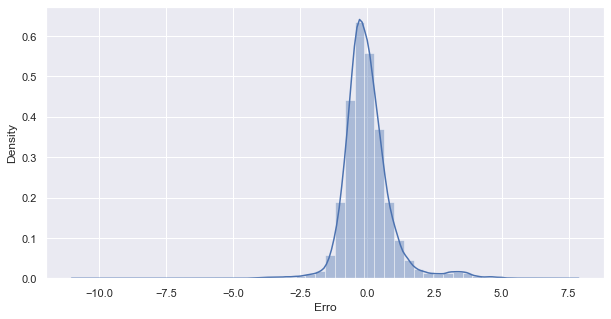

In [44]:
sns.set(rc={"figure.figsize": (10, 5)})
sns.distplot(err)

### Resultado final do modelo - Aplicando aos dados de treino

In [45]:
y_hat, targets = model.yhat_targets(df_test0)
err = y_hat - targets
err.name = 'Erro'

In [46]:
measure = ['Mean', 'Std', 'Median', 'Mode']
measure_erro = [round(err.mean(),2),round(err.std(),2), round(err.median(),2), round(err.mode()[0],2)]

measure_df = pd.DataFrame({'Measure':measure,'Erro': measure_erro})
measure_df

,Measure,Erro
0,Mean,0.00
1,Std,0.92
2,Median,-0.12
3,Mode,2.75


C:\Users\Luan\anaconda3\envs\py3-TF2.0\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


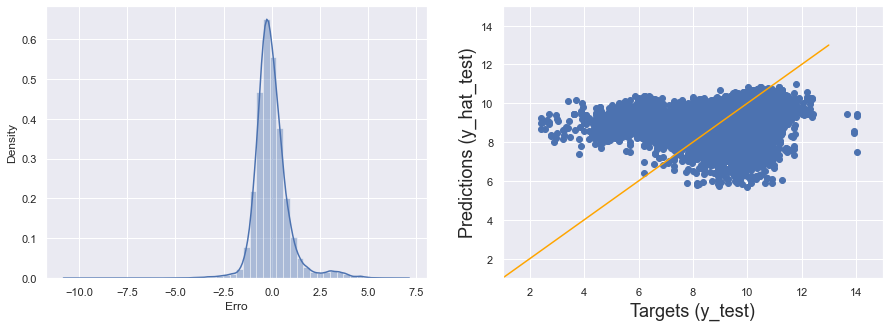

In [47]:
sns.set(rc={"figure.figsize": (15, 5)})

plt.subplot(1,2,1)
sns.distplot(err)

plt.subplot(1,2,2)
plt.scatter(targets, y_hat)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.plot(range(0,14),range(0,14),c='orange')
plt.xlim(1,15)
plt.ylim(1,15)

plt.show()